In this notebook, I am classifying NHL forwards and defensemen into different archetypes, using models in the SciKitLearn library. Instead of querying from my database here, I opted for csv file as there is less data and it is largely unnecessary to use the database here.

Data Preparation (Imports)

In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import NotFittedError

Load the 2021-2022 and 2022-2023 seasons and combine them, and load 2023-2024 season.

In [156]:
# Load 2021-2022 and 2022-2023 skater season CSV files (your paths here)
df_2021_2022 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2021-22.csv')
df_2022_2023 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2022-23.csv')
df_2023_2024 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2023-24.csv')

# Concatenate the DataFrames
df_training = pd.concat([df_2021_2022, df_2022_2023])

# Save the combined DataFrame to a new CSV file
df_training.to_csv('training_data.csv', index=False)


Preprocessing (Transform time metrics to decimal, clean by removing players with under 24 games played and under and removing unnecessary stats) for training and testing set.

In [157]:
# Keep only necessary stats for training model
columns_to_keep = ['Pos', 'GP', 'G', 'A', 'P', 'PIM', 'TOI', 'SH', 'G/GP', 'A/GP', 'P/GP', 'HITS', 'BS']
df_training = df_training[columns_to_keep]
df_2023_2024 = df_2023_2024[columns_to_keep]

# Remove players with under 25 games played
df_training = df_training[df_training['GP'] >= 25]

# Convert ice time to decimal and fix erroneous values
def time_to_decimal(time):
    if pd.isna(time):
        return 0
    
    time = str(time)

    try:
        # Remove extra :00 for ice time stats (erroneous values)
        if time.count(':') == 2:
            time = ':'.join(time.split(':')[:2])
        
        # Convert ice times to decimal values
        minutes, seconds = map(int, time.split(':'))
        return minutes + seconds / 100
    
    except ValueError:
        return 0

df_training['TOI'] = df_training['TOI'].apply(time_to_decimal)
df_training['SH'] = df_training['SH'].apply(time_to_decimal)

df_training.to_csv('training_data.csv', index=False)

Create base labels for forwards and defensemen and save it to new CSV. Here, I use arbitrary metrics I self defined based on my general knowledge, but these are imperfect (hence why we use machine learning!)

In [158]:
# TODO: Dynamic Labeling - relative performance within a season, so not era dependent

# Calculate the goal/assist ratio and handle cases where assists are 0 to avoid division by zero
df_training['G/A'] = df_training['G'] / df_training['A'].replace(0, np.nan)

# Replace NaN values (resulting from division by zero) with a very high value or a specific value like 0
df_training['G/A'] = df_training['G/A'].fillna(0)

# Label forward and defense archetypes
def label_player(row):
    # Check if the player is a forward
    if row['Pos'] == 'F':
        # Power-forward
        if row['P/GP'] >= 0.5 and ((row['HITS'] >= 90 and row['PIM'] >= 60) or row['HITS'] >= 150):
            return 'Power-forward'
        # Two-way
        elif row['P/GP'] >= 0.45 and row['SH'] > 1.30:
            return 'Two-way'
        # Sniper
        elif row['P/GP'] >= 0.45 and row['G/GP'] >= 0.35 and (row['G/A'] >= 0.8):
            return 'Sniper'
        # Playmaker
        elif row['P/GP'] >= 0.45:
            return 'Playmaker'
        # Grinder
        else:
            return 'Grinder'
    elif row['Pos'] == 'D':
        # All-around
        if row['P/GP'] >= 0.35 and row['TOI'] >= 23.00 and row['SH'] >= 1.30:
            return 'All-around'
        # Offensive
        elif row['P/GP'] >= 0.35:
            return 'Offensive'
        else:
            return 'Defensive'
    else:
        return 'N/A'

# Apply the function to create a new 'Label' column
df_training['Label'] = df_training.apply(label_player, axis=1)

# Save the updated DataFrame to a new CSV file
df_training.to_csv('training_data.csv', index=False)


Define features and targets, and one-hot encode position. Split data into training and test set (80% training and 20% test)

In [159]:
x = df_training.drop('Label', axis=1)
y = df_training['Label']

categorical_features = ['Pos']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

x = preprocessor.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Models here and training (random forest, SVM, decision trees, KNN), use K fold cross validation

In [160]:
# Define some common models
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Set up K-Fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define metrics in which to gauge model performance
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

# Train and cross validate model
for name, model in models.items():
    scores = cross_validate(model, x_train, y_train, cv=kf, scoring=scoring, return_train_score=False)

    print(f"{name} - Test Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"{name} - Test Precision: {scores['test_precision'].mean():.4f}")
    print(f"{name} - Test Recall: {scores['test_recall'].mean():.4f}")
    print(f"{name} - Test F1 Score: {scores['test_f1'].mean():.4f}")

Random Forest - Test Accuracy: 0.9717
Random Forest - Test Precision: 0.9674
Random Forest - Test Recall: 0.9717
Random Forest - Test F1 Score: 0.9668
Support Vector Machine - Test Accuracy: 0.7306
Support Vector Machine - Test Precision: 0.6540
Support Vector Machine - Test Recall: 0.7306
Support Vector Machine - Test F1 Score: 0.6731
Decision Tree - Test Accuracy: 0.9890
Decision Tree - Test Precision: 0.9900
Decision Tree - Test Recall: 0.9890
Decision Tree - Test F1 Score: 0.9884
KNN - Test Accuracy: 0.7041
KNN - Test Precision: 0.6866
KNN - Test Recall: 0.7041
KNN - Test F1 Score: 0.6787


Based on the evaluation methods above, the Decision Tree performed the best, followed by the Random Forest, and the SVM and KNN being much lower. I believe the Random Forest would perform even better than the Decision Tree given more data, but for the purposes of this project, I will use the Decision Tree model going forward.

Learning Curve Plots

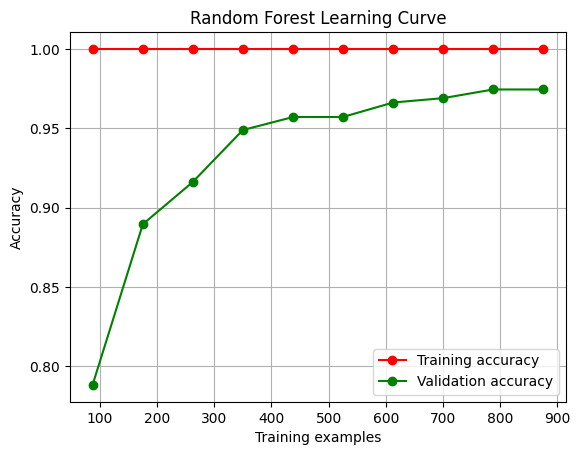

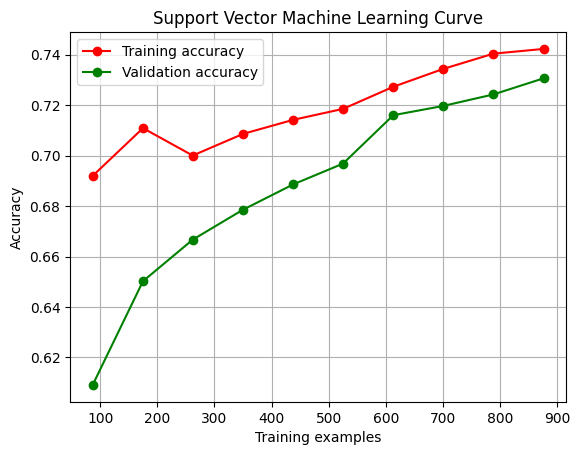

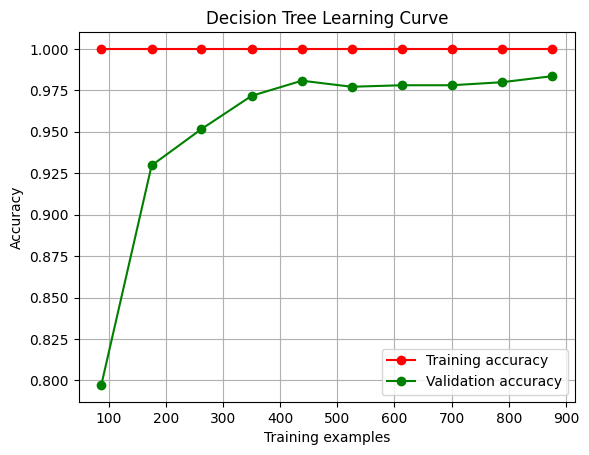

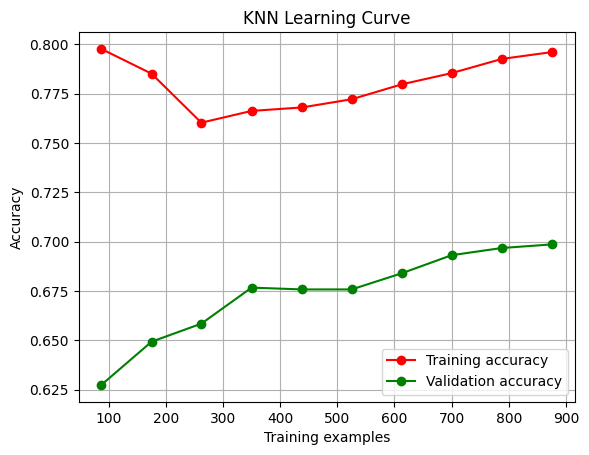

In [161]:
def plot_learning_curve(model, X_train, y_train, title='Learning Curve'):
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    # Calculate mean scores
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Plot learning curves
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training accuracy")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Validation accuracy")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
for name, model in models.items():
    plot_learning_curve(model, x_train, y_train, title=f'{name} Learning Curve')


Misclassification error analysis

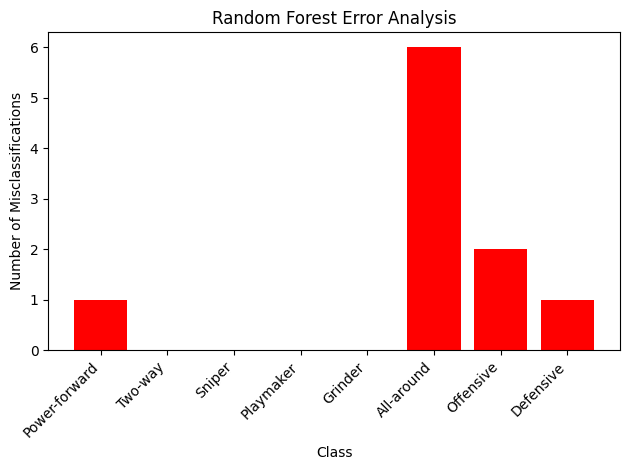

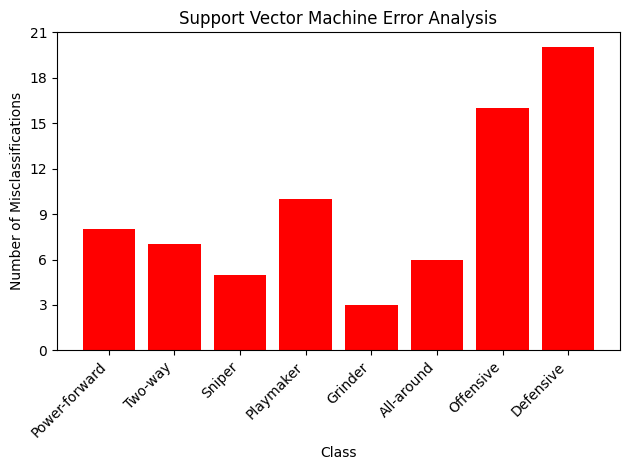

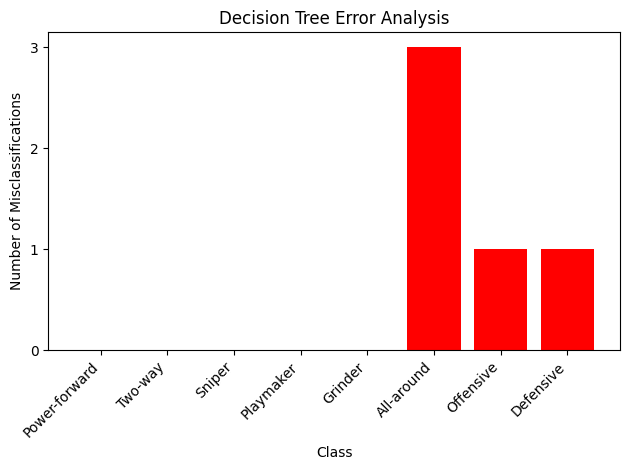

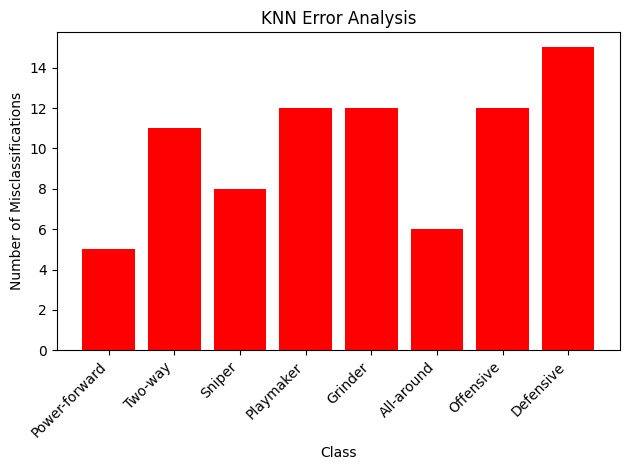

In [162]:
def plot_error_analysis(y_true, y_pred, label_mapping, title='Error Analysis'):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate the number of errors per class
    errors = cm.sum(axis=1) - np.diag(cm)
    
    # Map labels to their respective class names
    labels = [label_mapping[i] for i in range(len(label_mapping))]
    
    # Plot error analysis
    plt.figure()
    plt.bar(labels, errors, color='red')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Misclassifications')
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.show()

# Label mapping for the classes
label_mapping = {
    0: 'Power-forward',
    1: 'Two-way',
    2: 'Sniper',
    3: 'Playmaker',
    4: 'Grinder',
    5: 'All-around',
    6: 'Offensive',
    7: 'Defensive'
}


for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test) 
        
    # Plot error analysis
    plot_error_analysis(y_test, y_pred, label_mapping, title=f'{model_name} Error Analysis')


Decision Trees performed well enough for my purposes, so I am not going to do any more hyperparameter tuning. It is now time to use it to classify the 2023-2024 season data.

In [163]:
# Load and preprocess the new data
df_2023_2024 = pd.read_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/database/csv_data/skaters_2023-24.csv')

# Apply preprocessing steps
columns_to_keep = ['Name', 'Team', 'Pos', 'GP', 'G', 'A', 'P', 'PIM', 'TOI', 'SH', 'G/GP', 'A/GP', 'P/GP', 'HITS', 'BS']

df_2023_2024 = df_2023_2024[columns_to_keep]
df_2023_2024['TOI'] = df_2023_2024['TOI'].apply(time_to_decimal)
df_2023_2024['SH'] = df_2023_2024['SH'].apply(time_to_decimal)
df_2023_2024['G/A'] = df_2023_2024['G'] / df_2023_2024['A'].replace(0, np.nan)
df_2023_2024['G/A'] = df_2023_2024['G/A'].fillna(0)
df_2023_2024_transformed = preprocessor.transform(df_2023_2024)

# Predict player archetypes
y_pred_2023_2024 = models['Decision Tree'].predict(df_2023_2024_transformed)
df_2023_2024['Predicted Class'] = y_pred_2023_2024

# Can use this to check data in csv format
df_2023_2024.to_csv('/mnt/c/Users/killi/Documents/Fantasy-Hockey-App/backend/models/2023_2024_classified_data.csv', index=False)


Now, add these classifications to SQL database table for 2023-2024 season

In [154]:
import os
import psycopg2

db_username = os.getenv('DB_USERNAME')
db_password = os.getenv('DB_PASSWORD')
connection = psycopg2.connect(
    dbname='fantasy_hockey',
    user=db_username,  # export DB_USERNAME='your_username'
    password=db_password,  # export DB_PASSWORD='your_password'
    host='localhost'
)

cursor = connection.cursor()

for index, row in df_2023_2024.iterrows():
    update_query = """
        UPDATE skater_stats
        SET predicted_class = %s
        WHERE name = %s AND team = %s AND season = %s
    """
    cursor.execute(update_query, (row['Predicted Class'], row['Name'], row['Team'], '2023-24'))

# Handle non-2023-2024 seasons
update_non_2023_2024_query = """
    UPDATE skater_stats
    SET predicted_class = 'unclassified'
    WHERE season != '2023-24' AND predicted_class IS NULL;
"""
cursor.execute(update_non_2023_2024_query)

connection.commit()
cursor.close()
connection.close()